## Análisis exploratorio de datos - Properati

**Alumnos:**
* Cabrera, Laura - 87696
* Mankowski, Daniel
* RivaS, Rafael
* Rocha, Santiago

**Link al repo en github:** https://github.com/DanielMankowski/Data-Scients

In [3]:
%matplotlib inline

import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('default') # haciendo los graficos un poco mas bonitos xD
plt.rcParams['figure.figsize'] = (15, 5)

In [4]:
propiedades = pd.read_csv('./datasets/properati-AR-2017-08-01-properties-sell.csv', sep=',', error_bad_lines=False, low_memory=False)
propiedades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187482 entries, 0 to 187481
Data columns (total 27 columns):
id                            187482 non-null object
created_on                    187482 non-null object
operation                     187482 non-null object
property_type                 187482 non-null object
place_name                    187447 non-null object
place_with_parent_names       187482 non-null object
country_name                  187482 non-null object
state_name                    187482 non-null object
geonames_id                   158318 non-null float64
lat-lon                       118761 non-null object
lat                           118761 non-null float64
lon                           118761 non-null float64
price                         154443 non-null float64
currency                      154441 non-null object
price_aprox_local_currency    154443 non-null float64
price_aprox_usd               154443 non-null float64
surface_total_in_m2           12502

In [5]:
propiedades.sample()

,id,created_on,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
118889,098c155c5ff97d5acdc50f0129c64c6118fae79f,2017-06-27,sell,house,San Fernando,|Argentina|Bs.As. G.B.A. Zona Norte|San Fernando|,Argentina,Bs.As. G.B.A. Zona Norte,3429088.0,NaN,...,500.0,833.333333,1500.0,NaN,NaN,NaN,http://www.properati.com.ar/19jtq_venta_casa_s...,EXCELENTE PROPIEDAD LIBERTADOR AL RIO EN TRES ...,"Casa 900m² con Cochera en Necochea 800, Bs.As....",https://thumbs4.properati.com/7/WEOioUL9Gi6rKO...


### Data Cleaning
* Analizar los diferentes valores que puede tomar state_name para hacer el filtro correctamente y no perder información.

In [6]:
propiedades.loc[:, 'state_name'].value_counts()

Capital Federal                 44152
Bs.As. G.B.A. Zona Norte        39888
Bs.As. G.B.A. Zona Oeste        22571
Buenos Aires Costa Atlántica    20694
Bs.As. G.B.A. Zona Sur          18135
Córdoba                         15777
Santa Fe                        13516
Buenos Aires Interior            4686
Río Negro                        1152
Neuquén                          1057
Mendoza                           927
Misiones                          817
Entre Ríos                        793
Tucumán                           715
Corrientes                        629
San Luis                          444
Salta                             372
Chubut                            329
La Pampa                          301
Catamarca                         126
Chaco                              95
San Juan                           86
Tierra Del Fuego                   69
Formosa                            66
Santa Cruz                         40
Jujuy                              32
La Rioja    

* Agregar columnas de Año y Mes para futuros análisis

In [7]:
propiedades.loc[:,'year'] = pd.to_datetime(propiedades.loc[:,'created_on']).dt.year
propiedades.loc[:,'month'] = pd.to_datetime(propiedades.loc[:,'created_on']).dt.month
propiedades.sample()

,id,created_on,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,...,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail,year,month
32202,aeab8f6aee5767c456cbb5bd3306b1a4824a5b17,2016-06-18,sell,apartment,Villa Gesell,|Argentina|Buenos Aires Costa Atlántica|Villa ...,Argentina,Buenos Aires Costa Atlántica,3427431.0,"-37.280009223,-56.9959240616",...,583.333333,NaN,3.0,NaN,http://www.properati.com.ar/zc1g_venta_departa...,Oportunidad!!! Departamento de 90 m2 cubiertos...,Departamento con Cochera en PB,https://thumbs4.properati.com/2/NHBuziXlx_cWmd...,2016,6


* Filtrar las propiedades de CABA y GBA.

In [8]:
prop_caba_gba = propiedades[propiedades['state_name'].str.contains('Capital Federal') | propiedades['state_name'].str.contains('G.B.A.')]
prop_caba_gba.sample()

,id,created_on,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,...,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail,year,month
140229,f6f19146324bd057a55138e24140c0f274fed992,2017-07-19,sell,apartment,Capital Federal,|Argentina|Capital Federal|,Argentina,Capital Federal,3433955.0,NaN,...,7652.727273,NaN,NaN,NaN,http://www.properati.com.ar/1aokb_venta_depart...,"Departamento 140m², Argentina, Capital Federal...",Departamento - Capital Federal,https://thumbs4.properati.com/9/m_10EqAkS8q2j-...,2017,7


* Agregar una columna con el Barrio o Partido de la propiedad 

In [44]:
def parsear_zona(row):
    mylist = row.loc['place_with_parent_names'].split("|")
    return mylist[3]

prop_caba_gba.loc[:,'neighborhood'] = prop_caba_gba.apply(parsear_zona, axis=1)   

In [46]:
# Vista final de cómo quedó el DataFrame
prop_caba_gba.head()

,id,created_on,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,...,floor,rooms,expenses,properati_url,description,title,image_thumbnail,year,month,neighborhood
0,c8a66ee9e3da083ab66dacd165e8a5cc718b1cf2,2012-09-19,sell,house,San Antonio De Padua,|Argentina|Bs.As. G.B.A. Zona Oeste|Merlo|San ...,Argentina,Bs.As. G.B.A. Zona Oeste,3429244.0,NaN,...,NaN,NaN,NaN,http://www.properati.com.ar/udh_venta_casa_mer...,CASA CON LOCAL EN VENTA EN PADUA.2 DORMITORIOS...,CASA EN VENTA,https://thumbs4.properati.com/1/ufoyqwscVk8n3e...,2012,9,Merlo
1,a205c53378e7879cf7519659317fb410c060d20e,2012-10-22,sell,house,San Antonio De Padua,|Argentina|Bs.As. G.B.A. Zona Oeste|Merlo|San ...,Argentina,Bs.As. G.B.A. Zona Oeste,3429244.0,NaN,...,NaN,NaN,NaN,http://www.properati.com.ar/20hi_venta_casa_me...,CHALET VENTA 4 AMBIENTES PADUA.EXCELENTE CHALE...,CASA EN VENTA,https://thumbs4.properati.com/5/I5RS_jAIUseo9H...,2012,10,Merlo
4,9446052c949050359fb08b9f1ba83ba2eaa20c99,2012-12-08,sell,house,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6544492346,-58.4895603251",...,NaN,5.0,NaN,http://www.properati.com.ar/4m4m_venta_casa_ma...,Casa Multifamiliar en Mataderos!!! Sobre lote ...,CASA EN VENTA,https://thumbs4.properati.com/6/DsNJjCb5_zIPV0...,2012,12,Mataderos
5,4d3b492ed5f9c74cdf33b56b98328e5c950e3f9c,2013-01-04,sell,apartment,Pilar,|Argentina|Bs.As. G.B.A. Zona Norte|Pilar|,Argentina,Bs.As. G.B.A. Zona Norte,3429979.0,"-34.429071,-58.795418",...,NaN,2.0,NaN,http://www.properati.com.ar/518a_venta_departa...,"Venta - Departamento - Argentina, Buenos Aires...",Departamento en Venta ubicado en Arcos de Pilar,https://thumbs4.properati.com/8/bJn9FqcBRGi_8H...,2013,1,Pilar
6,535441f569473f6e5d687c38b27d9b9c6e69e284,2013-01-09,sell,store,San Isidro,|Argentina|Bs.As. G.B.A. Zona Norte|San Isidro|,Argentina,Bs.As. G.B.A. Zona Norte,3428983.0,"-34.4789383,-58.5214371",...,NaN,1.0,NaN,http://www.properati.com.ar/52p4_venta_local_s...,"Venta - Local - Argentina, Buenos Aires, Zona ...",Local en Venta ubicado en San Isidro,https://thumbs4.properati.com/9/ZCK2RkrsymyN5s...,2013,1,San Isidro


## ¿Cuántas propiedades se vendieron por estado?

Entendemos como **Estado** a Capital Federal o cada una de las 3 regiones del Gran Buenos Aires. Una primera vista nos permite tener una idea de cómo se dividió la cantidad de ventas de propiedades entre estos cuatro estados.

In [47]:
prop_barrio = prop_caba_gba['state_name'].value_counts()
prop_barrio

Capital Federal             44152
Bs.As. G.B.A. Zona Norte    39888
Bs.As. G.B.A. Zona Oeste    22571
Bs.As. G.B.A. Zona Sur      18135
Name: state_name, dtype: int64

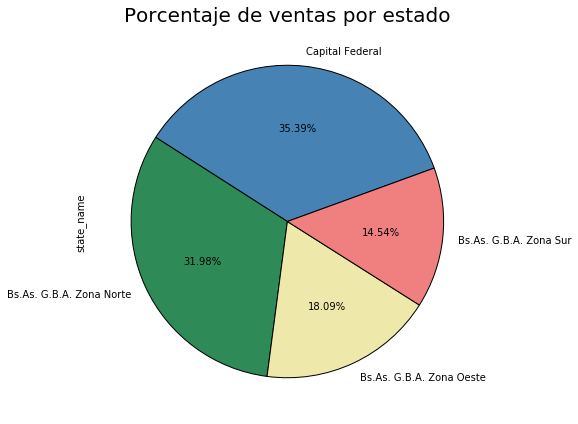

In [59]:
plt.figure()
colors = ['steelblue', 'seagreen', 'palegoldenrod', 'lightcoral']
plt.title('Porcentaje de ventas por estado', fontsize=20)
prop_barrio.plot.pie(figsize=(7, 7), colors = colors, autopct='%1.2f%%', startangle=20);


Podemos observar que la mayoría de las ventas se producen en CABA en su totalidad y la Zona Norte del Gran Buenos Aires.

### ¿Cuáles son los barrio en donde se produce el mayor número de ventas?

Queremos hacer un análisis más fino sobre la distribución de ventas ya no por estados sino por barrios; entendiendo por **barrio** a un barrio de CABA propiamente dicho o una localidad del Gran Buenos Aires. Para esto vamos a usar la columna *neighborhood* que obtuvimos previamente.

In [78]:
prop_localidad = prop_caba_gba['neighborhood'].value_counts().head(10)
prop_localidad

Tigre              13594
La Matanza          7947
Morón               5926
Palermo             5383
Vicente López       5218
San Isidro          5011
Pilar               4701
La Plata            4326
Lomas de Zamora     3828
Belgrano            3796
Name: neighborhood, dtype: int64

Si bien en el anĺisis previo la mayoría de las ventas se realiza en CABA, al hacer este segundo análisis más detallado nos encontramos que es la localidad de **Tigre** la que concentra el mayor número de transacciones.

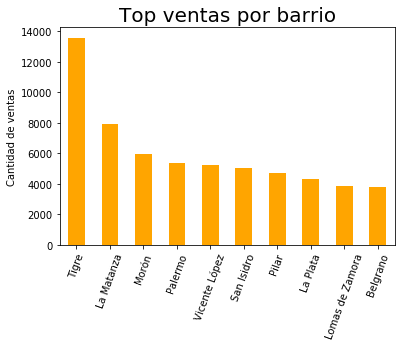

In [84]:
plt.title('Top ventas por barrio', fontsize=20)
plt.ylabel('Cantidad de ventas', fontsize=10)
prop_localidad.plot('bar', rot=70, color='orange')

## ¿Cuántas propiedades de cada tipo se venden?

Nos interesa analizar si hay varios tipos de propiedad a la ventas y cuántos operaciones se concretan. Esto podría ayudarnos a predecir si existe algún tipo de preferencia a la hora de buscar una propiedad o el perfil del usuario.

In [85]:
prop_caba_gba['property_type'].value_counts()

apartment    68826
house        44258
PH            7045
store         4617
Name: property_type, dtype: int64

Según los datos obtenidos, se puede observar que la gran mayoría de las publicaciones son sobre Departamentos o Casas, quedando muy por detrás los PH y los comercios.

## ¿Influye el barrio en el valor de las propiedades?

In [16]:
data = prop_caba_gba.loc[:,['neighborhood', 'price_aprox_usd']]
data = data[data['neighborhood'] <> '']
group_by_barrio = data.groupby('neighborhood').agg([np.mean, np.size])
group_by_barrio = group_by_barrio.loc[group_by_barrio[('price_aprox_usd','size')] > 50].sort_values(('price_aprox_usd','mean'), ascending=False)
group_by_barrio.head(10)

price_aprox_usd         
                             mean     size
neighborhood                              
Puerto Madero       933102.405806   1146.0
San Isidro          453277.572763   5011.0
Recoleta            451190.720953   2068.0
Retiro              395079.866257    393.0
Tigre               381874.766485  13594.0
Belgrano            378185.525543   3796.0
Palermo             372118.074596   5383.0
Nuñez               370172.824995   1009.0
General Rodríguez   364753.685656    265.0
Las Cañitas         348438.882353    226.0

In [17]:
data_barrio = prop_caba_gba.loc[:,['place_name', 'price_aprox_usd']]
data_barrio.dropna(inplace=True)
group_by_place = data_barrio.groupby('place_name').agg([np.mean, np.size])
group_by_place = group_by_place.loc[group_by_place[('price_aprox_usd','size')] > 50].sort_values(('price_aprox_usd','mean'), ascending=False)
group_by_place.head(10)

price_aprox_usd        
                                        mean    size
place_name                                          
Palermo Chico                   1.084513e+06   270.0
Puerto Madero                   9.331024e+05  1030.0
Santa Barbara Barrio Cerrado    7.815383e+05   115.0
Acassuso                        7.100821e+05   431.0
Barrio Los Lagos                6.151161e+05    62.0
Mayling Club de Campo           5.429888e+05    89.0
Martínez                        4.724978e+05  1689.0
Capital Federal                 4.648952e+05  1800.0
Recoleta                        4.511907e+05  1889.0
Vicente López                   4.494558e+05   929.0

### Cantidad de ventas de propiedades por año y mes

In [18]:
ventas_por_anio = prop_caba_gba.groupby('year').count()['created_on']
ventas_por_anio

year
2012        3
2013      417
2014     4348
2015    10208
2016    24730
2017    85040
Name: created_on, dtype: int64

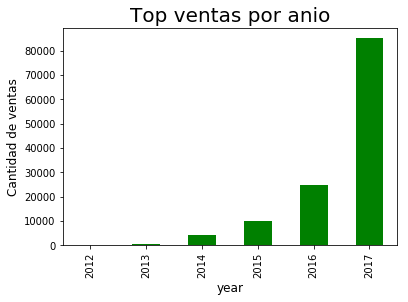

In [103]:
plt.title('Top ventas por anio', fontsize=20)
plt.ylabel('Cantidad de ventas', fontsize=12)
ventas_por_anio.plot('bar', color = 'green')

In [20]:
ventas_por_mes = prop_caba_gba.groupby(['year', 'month']).count()['created_on']

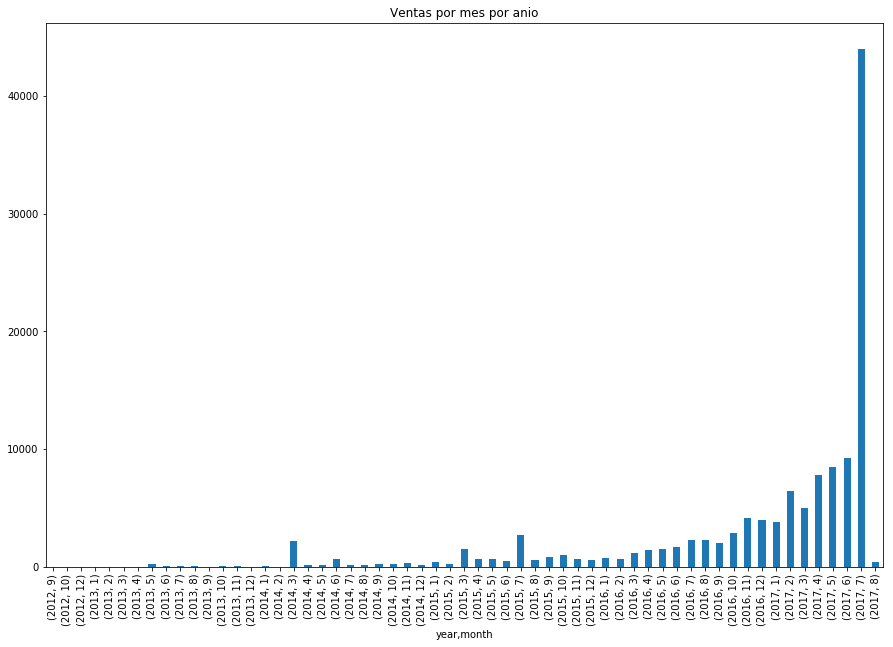

In [21]:
%matplotlib inline
ventas_por_mes.plot('bar', title = 'Ventas por mes por anio', figsize=(15,10))

### Tipos de propiedad vendidas

In [22]:
ventas_por_tipo = prop_caba_gba.groupby(['year','property_type']).count()['created_on']

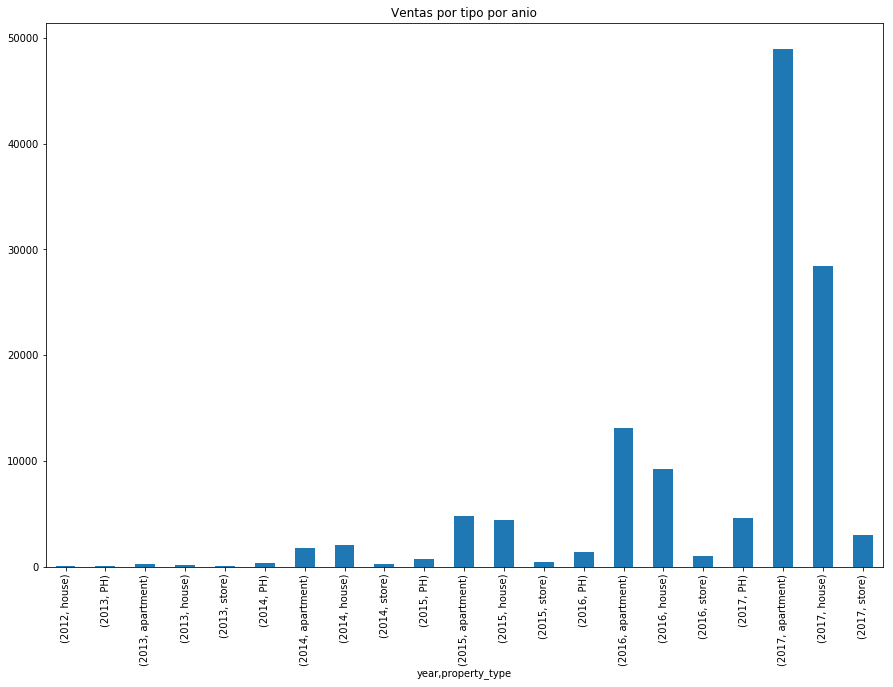

In [23]:
%matplotlib inline
ventas_por_tipo.plot('bar', title = 'Ventas por tipo por anio', figsize=(15,10))

### Evolución de ventas de departamentos por año

In [24]:
ventas_dptos = prop_caba_gba[prop_caba_gba['property_type'] == 'apartment']
ventas_dptos = ventas_dptos.groupby(['year', 'month']).count()['created_on']

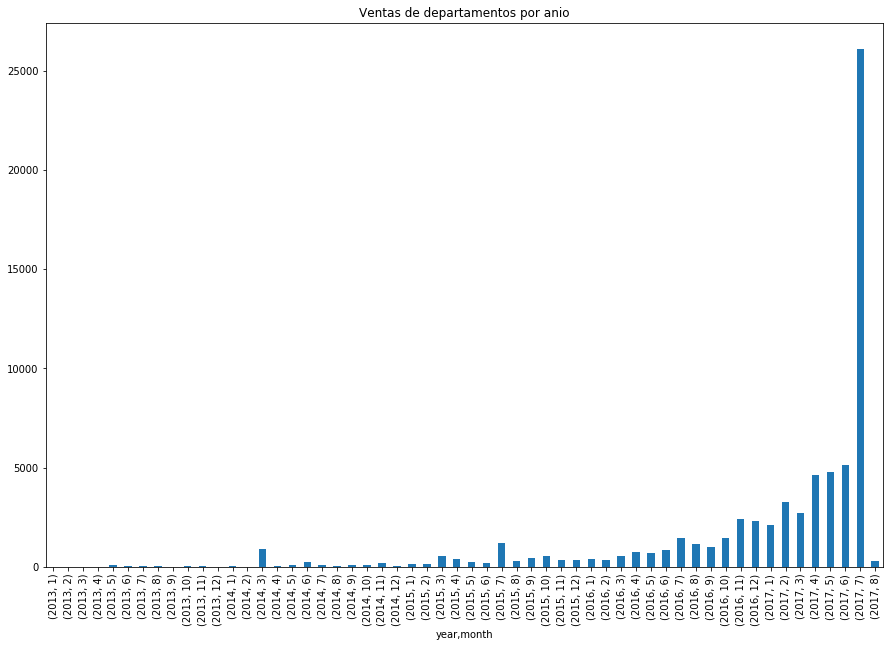

In [25]:
%matplotlib inline
ventas_dptos.plot('bar', title = 'Ventas de departamentos por anio', figsize=(15,10))

## Comunas

In [26]:
comunas = pd.read_csv('datasets/comunas.csv', sep=',', error_bad_lines=False, low_memory=False)
comunas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 5 columns):
WKT          15 non-null object
BARRIOS      15 non-null object
PERIMETRO    15 non-null float64
AREA         15 non-null float64
COMUNAS      15 non-null int64
dtypes: float64(2), int64(1), object(2)
memory usage: 672.0+ bytes


In [27]:
comunas

,WKT,BARRIOS,PERIMETRO,AREA,COMUNAS
0,MULTIPOLYGON (((-58.395205797051254 -34.572190...,RECOLETA,21246.611702,6.140873e+06,2
1,MULTIPOLYGON (((-58.412870031308849 -34.614116...,ALMAGRO - BOEDO,12323.465538,6.660526e+06,5
2,MULTIPOLYGON (((-58.430605828330876 -34.607047...,CABALLITO,10990.964471,6.851029e+06,6
3,MULTIPOLYGON (((-58.451995245456509 -34.629745...,FLORES - PARQUE CHACABUCO,17972.257870,1.242290e+07,7
4,MULTIPOLYGON (((-58.519254053232501 -34.633010...,LINIERS - MATADEROS - PARQUE AVELLANEDA,21411.738344,1.650531e+07,9
5,MULTIPOLYGON (((-58.488337367324576 -34.620160...,FLORESTA - MONTE CASTRO - VELEZ SARSFIELD - VE...,18332.037457,1.265656e+07,10
6,MULTIPOLYGON (((-58.498384839883038 -34.596367...,VILLA DEL PARQUE - VILLA DEVOTO - VILLA GRAL....,19987.696155,1.412004e+07,11
7,MULTIPOLYGON (((-58.503311325084404 -34.593856...,COGHLAN - SAAVEDRA - VILLA PUEYRREDON - VILLA ...,17232.189372,1.557093e+07,12
8,MULTIPOLYGON (((-58.426759317276407 -34.552023...,PALERMO,21768.074886,1.577250e+07,14
9,MULTIPOLYGON (((-58.41191880980378 -34.5980030...,BALVANERA - SAN CRISTOBAL,10486.260809,6.385991e+06,3


## Subtes

In [28]:
subtes = pd.read_csv('datasets/estaciones-de-subte.csv', sep=',', error_bad_lines=False, low_memory=False)
subtes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 5 columns):
X           86 non-null float64
Y           86 non-null float64
ID          86 non-null float64
ESTACION    86 non-null object
LINEA       86 non-null object
dtypes: float64(3), object(2)
memory usage: 3.4+ KB


In [29]:
subtes.head(10)

,X,Y,ID,ESTACION,LINEA
0,-58.398928,-34.635750,1.0,CASEROS,H
1,-58.400970,-34.629376,2.0,INCLAN,H
2,-58.402323,-34.623092,3.0,HUMBERTO 1�,H
3,-58.404732,-34.615242,4.0,VENEZUELA,H
4,-58.406036,-34.608935,5.0,ONCE - 30 DE DICIEMBRE,H
5,-58.380574,-34.604245,6.0,9 DE JULIO,D
6,-58.397924,-34.599757,7.0,FACULTAD DE MEDICINA,D
7,-58.385142,-34.601587,8.0,TRIBUNALES - TEATRO COL�N,D
8,-58.407161,-34.591628,9.0,AG�ERO,D
9,-58.415955,-34.585156,10.0,R.SCALABRINI ORTIZ,D


## Ferrocarriles

In [30]:
ferrocarriles_caba = pd.read_csv('datasets/estaciones-de-ferrocarril.csv', sep=';', error_bad_lines=False, low_memory=False)
ferrocarriles_caba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 9 columns):
LAT        47 non-null float64
LNG        47 non-null float64
ID         47 non-null int64
NOMBRE     47 non-null object
EMPRESA    43 non-null object
LINEA      47 non-null object
LINEA_2    47 non-null object
BARRIO     47 non-null object
COMUNA     47 non-null object
dtypes: float64(2), int64(1), object(6)
memory usage: 3.4+ KB


In [31]:
ferrocarriles_caba.head(10)

,LAT,LNG,ID,NOMBRE,EMPRESA,LINEA,LINEA_2,BARRIO,COMUNA
0,-34.571334,-58.424295,2,3 DE FEBRERO,TBA - TRENES DE BS AS S.A.,MITRE,F.C.G.B.M.,PALERMO,COMUNA 14
1,-34.567571,-58.463056,4,BELGRANO R,TBA - TRENES DE BS AS S.A.,MITRE,F.C.G.B.M.,BELGRANO,COMUNA 13
2,-34.562549,-58.435864,6,LISANDRO DE LA TORRE,TBA - TRENES DE BS AS S.A.,MITRE,F.C.G.B.M.,PALERMO,COMUNA 14
3,-34.558443,-58.449498,7,BELGRANO C,TBA - TRENES DE BS AS S.A.,MITRE,F.C.G.B.M.,BELGRANO,COMUNA 13
4,-34.548895,-58.462400,8,NUÑEZ,TBA - TRENES DE BS AS S.A.,MITRE,F.C.G.B.M.,NUÑEZ,COMUNA 13
5,-34.537522,-58.467586,9,RIVADAVIA,TBA - TRENES DE BS AS S.A.,MITRE,F.C.G.B.M.,NUÑEZ,COMUNA 13
6,-34.580456,-58.501732,10,PUEYRREDON,TBA - TRENES DE BS AS S.A.,MITRE,F.C.G.B.M.,VILLA PUEYRREDON,COMUNA 12
7,-34.574767,-58.487968,11,GRAL. URQUIZA,TBA - TRENES DE BS AS S.A.,MITRE,F.C.G.B.M.,VILLA URQUIZA,COMUNA 12
8,-34.568421,-58.479083,12,DR. L. M. DRAGO,TBA - TRENES DE BS AS S.A.,MITRE,F.C.G.B.M.,VILLA URQUIZA,COMUNA 12
9,-34.565240,-58.475348,13,COGHLAN,TBA - TRENES DE BS AS S.A.,MITRE,F.C.G.B.M.,COGHLAN,COMUNA 12


## Espacios verdes públicos

In [32]:
espacio_verde_caba = pd.read_csv('datasets/espacio-verde-publico.csv', sep=',', error_bad_lines=False, low_memory=False)
espacio_verde_caba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1571 entries, 0 to 1570
Data columns (total 32 columns):
WKT           1571 non-null object
NOMBRE        848 non-null object
NOMBRE_EV     1373 non-null object
CLASIFICAC    1570 non-null object
PATIO_DE_J    1399 non-null object
APADRINADA    720 non-null object
OBSERVACIO    942 non-null object
FUENTE_GEO    1530 non-null object
FUENTE_INS    1516 non-null object
UBICACION     1481 non-null object
DECRETO       449 non-null object
FECHA_DECR    487 non-null object
ORDENANZA_    657 non-null object
FECHA_ORDE    694 non-null object
BOLETIN_OF    724 non-null object
FECHA_BOLE    724 non-null object
BARRIO        1569 non-null object
COMUNA        1571 non-null float64
FECH_PADRI    71 non-null object
VIG_PADRI     70 non-null object
ALC_CONVEN    70 non-null object
NOM_MAPA      847 non-null object
ID_EV_PUB     1571 non-null int64
AREA          1571 non-null float64
PERIMETER     1571 non-null float64
DGEV_PADRI    81 non-null object

In [33]:
espacio_verde_caba.head(10)

,WKT,NOMBRE,NOMBRE_EV,CLASIFICAC,PATIO_DE_J,APADRINADA,OBSERVACIO,FUENTE_GEO,FUENTE_INS,UBICACION,...,ID_EV_PUB,AREA,PERIMETER,DGEV_PADRI,MANT_2017,TAREAS,ESTADO,SUP_TOTAL,CANIL,POSTA_AERO
0,MULTIPOLYGON (((-58.4451555904981 -34.57906477...,NaN,SIN NOMBRE,PLAZOLETA,NO,NaN,ESPACIOS VERDES,USIG,USIG,"CONDE - MATIENZO, BENJAMIN, TTE. - FREIRE, RAM...",...,1,295.339,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MULTIPOLYGON (((-58.4453556017045 -34.57924873...,NaN,SIN NOMBRE,PLAZOLETA,NO,NaN,ESPACIOS VERDES,USIG,USIG,"CONDE - MATIENZO, BENJAMIN, TTE. - FREIRE, RAM...",...,2,774.284,9990.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MULTIPOLYGON (((-58.4448487613474 -34.57975070...,NaN,SIN NOMBRE,PLAZOLETA,NO,NaN,ESPACIOS VERDES,USIG,USIG,"CONDE - MATIENZO, BENJAMIN, TTE. - FREIRE, RAM...",...,3,26.081,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MULTIPOLYGON (((-58.4452130902327 -34.58012665...,NaN,SIN NOMBRE,PLAZOLETA,NO,NaN,ESPACIOS VERDES,USIG,USIG,"CONDE - MATIENZO, BENJAMIN, TTE. - FREIRE, RAM...",...,4,4279.665,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,MULTIPOLYGON (((-58.4448127670184 -34.57989117...,NaN,SIN NOMBRE,PLAZOLETA,NO,NaN,ESPACIOS VERDES,USIG,USIG,"CONDE - MATIENZO, BENJAMIN, TTE. - FREIRE, RAM...",...,5,3.984,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,MULTIPOLYGON (((-58.4451875792257 -34.58001358...,NaN,SIN NOMBRE,PLAZOLETA,NO,NaN,ESPACIOS VERDES,USIG,USIG,"CONDE - MATIENZO, BENJAMIN, TTE. - FREIRE, RAM...",...,6,5194.855,9600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,MULTIPOLYGON (((-58.4452896627963 -34.57898463...,NaN,SIN NOMBRE,PLAZOLETA,NO,NaN,ESPACIOS VERDES,USIG,USIG,"CONDE - MATIENZO, BENJAMIN, TTE. - FREIRE, RAM...",...,7,588.643,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,MULTIPOLYGON (((-58.4382360541145 -34.54616199...,NaN,SIN NOMBRE,PLAZOLETA,NO,NaN,ESPACIOS VERDES,USIG,USIG,"GUIRALDES, INTENDENTE - ESTACIONAMIENTO - PARQ...",...,8,3746.965,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,MULTIPOLYGON (((-58.4552876770316 -34.56223232...,PZA. RAFAEL HERNANDEZ,"HERNANDEZ, RAFAEL",PLAZA,SI,NO,NaN,ESPACIOS VERDES,E.V.,"ECHEVERRIA - VUELTA DE OBLIGADO - MOM, POLICARPO",...,9,558.986,9990.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,MULTIPOLYGON (((-58.4371387094279 -34.55314301...,PZA. PQUES. NACIONALES ARGENTINOS,PARQUES NACIONALES ARGENTINOS,PLAZA,NO,NO,NaN,ESPACIOS VERDES,E.V.,"ECHEVERRIA - CASTAÑEDA - SUCRE, ANTONIO J. DE,...",...,10,12169.958,1000.0,SI,SI,PARQUIZACION - VEREDAS PERIMETRALES,FINALIZADA,10215.0,NaN,NaN


## Establecimientos educativos

In [34]:
establecimientos_educativos = pd.read_csv('datasets/establecimientos-educativos.csv', sep=';', error_bad_lines=False, low_memory=False)
establecimientos_educativos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2857 entries, 0 to 2856
Data columns (total 28 columns):
LON           2857 non-null float64
LAT           2857 non-null float64
OBJECTID      2857 non-null int64
CUI           2857 non-null int64
CUEANEXO      2857 non-null int64
CUE           2857 non-null int64
ANEXO         2857 non-null float64
SECTOR        2857 non-null int64
DOM_EDIFIC    2857 non-null object
DOM_ESTABL    2857 non-null object
NOMB_EST      2857 non-null object
NOMB_ABR      2857 non-null object
TELEFONO      2854 non-null object
EMAIL         2855 non-null object
CODPOST       2857 non-null object
PAGINAWEB     2857 non-null object
NIVMOD        2857 non-null object
NIVELMODAL    2857 non-null object
DEPFUN        2822 non-null object
DE            2857 non-null int64
COMUNA        2857 non-null int64
BARRIO        2857 non-null object
AREAPROGRA    2857 non-null object
ESTADO        2857 non-null int64
POINT_X       2857 non-null object
POINT_Y       2857 non-

In [35]:
establecimientos_educativos.head(5)

,LON,LAT,OBJECTID,CUI,CUEANEXO,CUE,ANEXO,SECTOR,DOM_EDIFIC,DOM_ESTABL,...,DEPFUN,DE,COMUNA,BARRIO,AREAPROGRA,ESTADO,POINT_X,POINT_Y,NIVEL,TIPEST
0,-58.512702,-34.600586,1,200794,20046500,200465,0.0,1,MERCEDES 4002,MERCEDES 4002,...,DIR DE EDUCACION DEL ADULTO Y DEL ADOLESCENTE,17,11,VILLA DEVOTO,12 - HOSP ZUBIZARRETA,1,9.546.838.350.000.000,10.318.093.010.000.000,SECUNDARIO DE JOVENES Y ADULTOS,CENS (CENTRO EDUCATIVO DE NIVEL SECUNDARIO)
1,-58.409572,-34.627545,2,202368,20146700,201467,0.0,2,CONSTITUCION 3156,CONSTITUCION 3156,...,DIR GRAL DE EDUCACION DE GESTION PRIVADA,6,3,SAN CRISTOBAL,08 - HOSP RAMOS MEJIA,1,10.492.682.829.999.900,10.019.007.170.000.000,SECUNDARIO COMUN,IEIEO (INSTITUTO EDUCATIVO INCORPORADO A LA EN...
2,-58.470192,-34.565676,3,202343,20055900,200559,0.0,1,BLANCO ENCALADA 3479,BLANCO ENCALADA 3471,...,DIR DE EDUCACION INICIAL,10,13,BELGRANO,07 - HOSP PIROVANO,1,9.936.747.400.000.000,10.705.470.920.000.000,INICIAL COMUN,EI (ESCUELA INFANTIL)
3,-58.400357,-34.584847,4,200063,20290700,202907,0.0,1,AVDA. GRAL. LAS HERAS 2670,AVDA. GRAL. LAS HERAS 2670,...,DIR DE EDUCACION INICIAL,1,2,RECOLETA,04 - HOSP FERNANDEZ,1,10.577.479.859.999.900,10.492.624.360.000.000,INICIAL COMUN,EI (ESCUELA INFANTIL)
4,-58.426547,-34.603379,5,200084,20147803,201478,3.0,1,OBRERO ROBERTO NUÑEZ 4355,OBRERO ROBERTO NUÑEZ 4355,...,DIR DE EDUCACION INICIAL,2,5,ALMAGRO,03 - HOSP DURAND,1,10.337.119.110.000.000,10.287.160.520.000.000,INICIAL COMUN,JIN (JARDIN DE INFANTES NUCLEADO)


## Evolución del dolar

In [36]:
evol_dolar = pd.read_csv('datasets/evol_dolar.csv', sep=',', error_bad_lines=False, low_memory=False)
evol_dolar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2456 entries, 0 to 2455
Data columns (total 4 columns):
Fecha               2456 non-null object
Tipo de dólar       2456 non-null object
Precio de venta     2456 non-null float64
Precio de compra    1421 non-null float64
dtypes: float64(2), object(2)
memory usage: 76.8+ KB


In [37]:
# data_fecha = evol_dolar.set_index('Fecha')
fecha_1 = dt.datetime(2013, 1, 1).strftime("%d/%m/%y")
evol_dolar = evol_dolar[evol_dolar['Fecha'] > fecha_1]
evol_dolar["Fecha"]=pd.to_datetime(evol_dolar["Fecha"])
evol_dolar = evol_dolar[evol_dolar['Fecha'] > '2013/01/01']

In [38]:
evol_dolar_inf = evol_dolar[evol_dolar['Tipo de d\xc3\xb3lar'] == 'Informal']
evol_dolar_inf.head(10)

,Fecha,Tipo de dólar,Precio de venta,Precio de compra
971,2013-02-01,Informal,6.91,NaN
973,2013-03-01,Informal,7.07,NaN
974,2013-04-01,Informal,7.07,NaN
976,2013-07-01,Informal,7.04,NaN
979,2013-08-01,Informal,7.05,NaN
981,2013-09-01,Informal,7.07,NaN
983,2013-10-01,Informal,7.25,NaN
985,2013-11-01,Informal,7.20,NaN
987,2013-01-14,Informal,7.20,NaN
989,2013-01-15,Informal,7.34,NaN


In [39]:
dolar_inf = evol_dolar_inf
dolar_inf.loc[:,'year'] = pd.to_datetime(evol_dolar_inf.loc[:,'Fecha']).dt.year
dolar_inf.loc[:,'month'] = pd.to_datetime(evol_dolar_inf.loc[:,'Fecha']).dt.month
dolar_inf.head(10)

,Fecha,Tipo de dólar,Precio de venta,Precio de compra,year,month
971,2013-02-01,Informal,6.91,NaN,2013,2
973,2013-03-01,Informal,7.07,NaN,2013,3
974,2013-04-01,Informal,7.07,NaN,2013,4
976,2013-07-01,Informal,7.04,NaN,2013,7
979,2013-08-01,Informal,7.05,NaN,2013,8
981,2013-09-01,Informal,7.07,NaN,2013,9
983,2013-10-01,Informal,7.25,NaN,2013,10
985,2013-11-01,Informal,7.20,NaN,2013,11
987,2013-01-14,Informal,7.20,NaN,2013,1
989,2013-01-15,Informal,7.34,NaN,2013,1


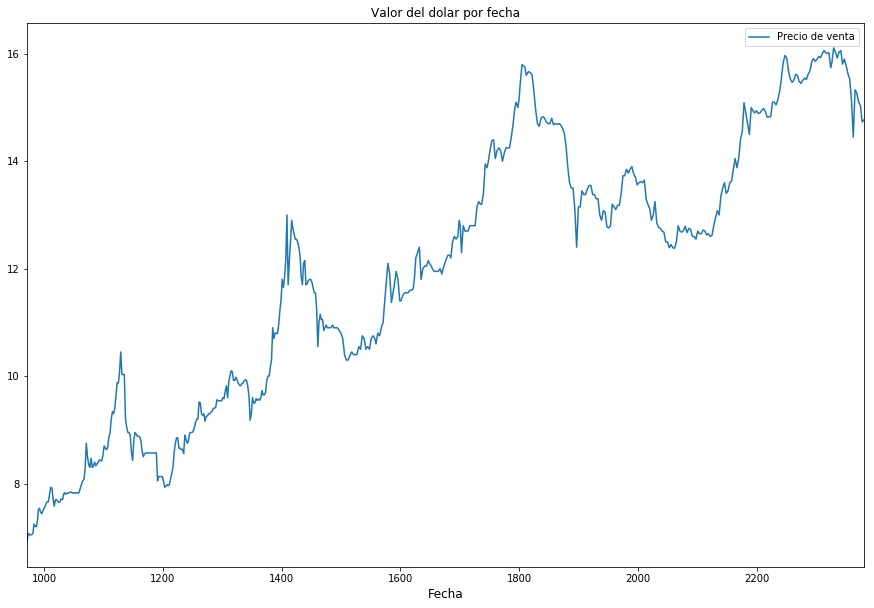

In [40]:
%matplotlib inline
ax = dolar_inf[['Precio de venta','Fecha']].plot(kind='line', title = 'Valor del dolar por fecha', figsize=(15,10))
ax.set_xlabel("Fecha",fontsize=12)
plt.show()

# ¿Que pasa con Tigre y Zonas Aledañas?
En graficos anteriores hemos visto que en la base de datos proporcionada por Properati tenemos una gran cantidad de ventas/publicaciones en el partido de Tigre. Debido a que uno de los integrantes del grupo vive en dicho partido, hemos investigado un poco y descubierto que la zona ha crecido mucho en los ultimos 25 años. Si bien no tenemos datos sobre los ultimos 25 años, con la base de datos propuesta haremos un analisis de la evolucion del precio del m2 en dicha zona intentando de sacar alguna tendencia. Para el analisis nos hemos propuesto comparar la evolucion de 3 zonas de Tigre ( Nordelta, Benavidez, Tigre Centro ) y de San Fernando partido aledaño a Tigre y que tambien ha crecido mucho en los ultimos años como alternativa a Tigre.
Elegimos Nordelta ya que su crecimiento ha sido realmente exponencial y creemos que influye en el precio de zonas aledañas como es Tigre y Benavidez
Eligmos San Fernando ya que entendemos que en los ultimos años ha sido buscado como alternativa a Tigre para vivir en zona norte.
